# Improving GWAS

In [1]:
from os import path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

%matplotlib inline
plt.style.use('ggplot')

In [2]:
DATA_DIR = path.join(path.pardir, 'data')
PAN_DIR = path.join(DATA_DIR, 'pangenomes')
FIG_DIR = path.join(path.pardir, 'figs')

## PCA

In [3]:
def get_traits(antibiotic):
    traits = pd.read_csv(path.join(DATA_DIR, f'traits_{antibiotic}.tsv'), sep='\t')
    traits.columns = ['samples', 'phenotype']
    traits = traits.replace({0: 'Susceptible', 1: 'Resistance'})
    return traits


def get_kmers(antibiotic):
    kmers = pd.read_csv(path.join(PAN_DIR, antibiotic, 'panfeed1', 'hashes_to_patterns.tsv'), sep='\t')

    kmers = kmers.T
    kmers.columns = kmers.iloc[0]
    kmers = kmers.iloc[1:, :]

    kmers = kmers.reset_index()
    kmers = kmers.rename(columns={'index': 'samples'})
    
    return kmers


def get_sampling_location(antibiotic):
    geo = pd.read_excel(path.join(DATA_DIR, 'genomes_ready_mod.xlsx'), dtype=str)
    geo = geo[['genome_id', 'genome_name', 'geographic_location']]
    geo['samples'] = geo.genome_id.astype('str') + '.PATRIC'

    geo = geo[['samples', 'geographic_location']]
    geo = geo.fillna('Unknown')

    return geo


def get_necessary_data_for_pca(antibiotic):
    traits = get_traits(antibiotic)
    geo = get_sampling_location(antibiotic)
    kmers = get_kmers(antibiotic)

    traits_geo = pd.merge(traits, geo, how='inner', on='samples')
    kmers = pd.merge(traits_geo, kmers, how='inner', on='samples')

    return kmers

In [5]:
kmers_rifampin = get_necessary_data_for_pca('rifampin')
kmers_rifampin

,samples,phenotype,geographic_location,nB0BmxTtpFSfL83f4ByeNg==,zchqpKSkZz/lswf5Tn6d8A==,6VCrCyVuTdnircreZL0L0g==,30AQg0Io2VD7k9d9fmnC9A==,YUvDh7m+5VWCasXghhMOzg==,B7oZLlpl7nu5AzB3Uzv32Q==,qyUNp7p4oPdGkpp+thJ5bw==,...,A1nBTfYijyfQAAXhtEzpxw==,Odvgo2ME4WOfX+kcR/OgTg==,FcvFN1Ho3m/WkILD+vbAbQ==,XyNhej66TYZOnwMrG9CM+g==,Jx58q8tDqMDetv3+uwVXBw==,wFT2dnm7VHz6XFw9eyrwkA==,TaibD2fs2tdJuscuUE6HUA==,GvgTQQvzftLQGDb155jjgw==,Cp/MASy/J/YGsHPGh289hw==,PauzW1WESfIeLJ9Np8zDrw==
0,1438833.3.PATRIC,Resistance,Romania,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1438835.3.PATRIC,Resistance,Romania,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1438837.3.PATRIC,Resistance,Romania,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1438838.3.PATRIC,Resistance,Romania,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1438842.3.PATRIC,Resistance,Romania,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,1408957.4.PATRIC,Susceptible,Uganda,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
376,1438877.3.PATRIC,Susceptible,Uganda,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
377,652616.4.PATRIC,Susceptible,Unknown,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
378,1773.199.PATRIC,Susceptible,Mali,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
def pca(data):
    pca = PCA(n_components=2, random_state=0)
    projected = pca.fit_transform(data.iloc[:, 3:])
    return projected


def plot_savefig_pca(projected, data, antibiotic):
    sns.scatterplot(
        x=projected[:, 0], 
        y=projected[:, 1], 
        hue=data.geographic_location, 
        style=data.phenotype, 
        legend="full", 
        alpha=0.9
    )
    plt.title(f'PCA k-mers ({antibiotic.title()})')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.savefig(path.join(FIG_DIR, f'pca_{antibiotic}.png'), bbox_inches='tight', dpi=300)
    
    
# n_clusters = 3
# kmeans = KMeans(n_clusters, n_init='auto', random_state=0)
# kmeans.fit(projected)
# cluster_labels = kmeans.labels_
# kmers.insert(3, 'cluster', cluster_labels)

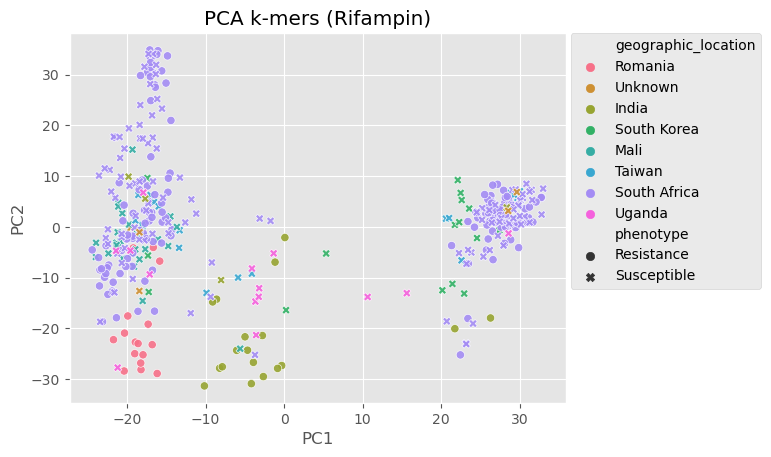

In [21]:
projected = pca(kmers_rifampin)
plot_savefig_pca(projected, kmers_rifampin, 'rifampin')

In [24]:
def run_pipeline(antibiotic):
    data = get_necessary_data_for_pca(antibiotic)
    
    projected = pca(data)
    plot_savefig_pca(projected, data, antibiotic)
    plt.clf()


antibiotics = ['ethambutol', 'isoniazid', 'rifampin']
for a in antibiotics:
    run_pipeline(a)

<Figure size 640x480 with 0 Axes>